In [19]:
%load_ext autoreload

In [20]:
%autoreload 2

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import average_precision_score, roc_auc_score
import numpy as np
from sklearn import tree
from deslib.des.knora_e import KNORAE
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import torch

In [336]:
chembl = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_4_smiles.csv', index_col=0)

In [40]:
chembl.loc[chembl['smiles'].str.contains('\.')]

,chembl_id,pubchem_cid,smiles,parent_smiles,chembl_tox,withdrawn
464,CHEMBL1237066,62859,O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)...,O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)...,Safe,0
700,CHEMBL2010412,452192,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N...,missing,Safe,0
842,CHEMBL1200747,62358,CC(O)C(=O)O.N,CC(O)C(=O)O.N,Safe,0
1376,CHEMBL2106975,61102,O=C([O-])O.[K+],O=C([O-])O.[K+],Safe,0
1409,CHEMBL1255943,2723891,Cl.N[C@@H](CCC(=O)O)C(=O)O,Cl.N[C@@H](CCC(=O)O)C(=O)O,Safe,0
...,...,...,...,...,...,...
10391,CHEMBL1200691,8896,CC(=O)[O-].CC(=O)[O-].[Mg+2],CC(=O)[O-].CC(=O)[O-].[Mg+2],Safe,0
10524,CHEMBL2106123,13136,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])C...,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])C...,Safe,0
10531,CHEMBL2364968,90661668,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,missing,Safe,0
10560,CHEMBL261772,missing,C=C1c2c(Cl)ccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(...,C=C1c2c(Cl)ccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(...,Safe,0


In [338]:
chembl['smiles'].str.unique()

AttributeError: 'StringMethods' object has no attribute 'unique'

# Models

In [125]:
search_space = { # values for boostrap can be either True or False # values of max_depth are integers from 6 to 20
        "max_iter": Integer(10, 1000),
        "learning_rate": Real(0.001, 1),  
        "min_samples_leaf": Integer(1, 30)
    }

In [119]:
forest_clf = HistGradientBoostingClassifier(early_stopping=True, validation_fraction=0.15)

In [126]:
forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=32, # specify how many iterations
                                    scoring="roc_auc", n_jobs=-1, cv=5)

In [127]:
forest_bayes_search.fit(X, y)

BayesSearchCV(cv=5,
              estimator=HistGradientBoostingClassifier(early_stopping=True,
                                                       validation_fraction=0.15),
              n_iter=32, n_jobs=-1, scoring='roc_auc',
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='uniform', transform='identity'),
                             'max_iter': Integer(low=10, high=1000, prior='uniform', transform='identity'),
                             'min_samples_leaf': Integer(low=1, high=30, prior='uniform', transform='identity')})

In [128]:
forest_bayes_search.best_estimator_

HistGradientBoostingClassifier(early_stopping=True,
                               learning_rate=0.01619991660275452, max_iter=25,
                               min_samples_leaf=12, validation_fraction=0.15)

# AP

In [129]:
forest_bayes_search.best_score_

0.6878546912287747

# ROC auc

In [104]:
forest_bayes_search.best_score_

0.6895023895534506

In [79]:
aps = []
aucs = []
for train_index, test_index in skf.split(X, y):
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf.fit(X_train, y_train)
    #knorae = KNORAE(pool_classifiers)
    #knorae.fit()
    log_probs = clf.predict_proba(X_test)[:, 1]
    ap = average_precision_score(y_test, log_probs)
    roc_auc = roc_auc_score(y_test, log_probs)
    aps.append(ap)
    aucs.append(roc_auc)

In [85]:
np.mean(aps)

0.14099473491817066

In [87]:
np.mean(aucs)

0.6449456398734204

# Knora

In [107]:
aps = []
aucs = []
for train_index, test_index in skf.split(X, y):
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)
    
    clf = forest_bayes_search.best_estimator_
    clf.fit(X_train, y_train)
    knorae = KNORAE(clf)
    knorae.fit(X_dsel, y_dsel)
    
    log_probs = clf.predict_proba(X_test)[:, 1]
    ap = average_precision_score(y_test, log_probs)
    roc_auc = roc_auc_score(y_test, log_probs)
    aps.append(ap)
    aucs.append(roc_auc)

In [110]:
np.mean(aps)

0.1549412394889774

In [111]:
np.mean(aucs)

0.6263718833458845

# GNN Explainer

In [126]:
from smiles_only.data_utils import smiles2graph
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GNNExplainer
from typing import Dict, Optional
from smiles_only.EGConv import EGConvNet, AtomEncoder
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as pyplot
import networkx as nx

ImportError: cannot import name 'EGConvNet'

In [50]:
train = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_train.csv', index_col=0)

In [51]:
train

,chembl_id,pubchem_cid,smiles,parent_smiles,chembl_tox,withdrawn
7833,CHEMBL710,57363,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,Safe,0
7511,CHEMBL1770248,44814423,CCOc1ccc(Cc2cc([C@]34OC[C@](CO)(O3)[C@@H](O)[C...,CCOc1ccc(Cc2cc([C@]34OC[C@](CO)(O3)[C@@H](O)[C...,Safe,0
6030,CHEMBL3989949,11962412,NC(=O)O[C@@H](Cn1ncnn1)c1ccccc1Cl,NC(=O)O[C@@H](Cn1ncnn1)c1ccccc1Cl,Safe,0
10493,CHEMBL844,2435,Brc1c(NC2=NCCN2)ccc2nccnc12,Brc1c(NC2=NCCN2)ccc2nccnc12,Safe,0
2262,CHEMBL833,5472,Clc1ccccc1CN1CCc2sccc2C1,Clc1ccccc1CN1CCc2sccc2C1,toxic_hema,0
...,...,...,...,...,...,...
8166,CHEMBL1201760,10178705,N[C@@H]1CCCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)...,N[C@@H]1CCCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)...,Safe,0
10183,CHEMBL1697782,63019,CCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[C...,CCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[C...,Safe,0
886,CHEMBL1480,3333,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,Safe,0
1950,CHEMBL3545432,56844015,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B1OC(=...,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B1OC(=...,Safe,0


In [45]:
test = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_test.csv', index_col=0)

In [52]:
test['withdrawn'].value_counts(normalize=True)

0    0.929231
1    0.070769
Name: withdrawn, dtype: float64

In [7]:
test_data_list = []
for index, row in test.iterrows():
    test_data_list.append(smiles2graph(row, 'withdrawn'))

In [8]:
test_data_list[13].x.size()

torch.Size([29, 27])

In [15]:
model = EGConvNet(512, 7, 2, 4, aggregator=['sum', 'mean', 'max'])

In [16]:
state_dict = torch.load('/home/dionizije/epoch=36-step=3625.ckpt', map_location=torch.device('cpu'))['state_dict']

In [17]:
for _ in range(len(state_dict)):
    k, v = state_dict.popitem(False)
    k = k.split('model.')[1]
    state_dict[k] = v

In [18]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
model.eval()

EGConvNet(
  (lin1): Linear(in_features=27, out_features=512, bias=True)
  (norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (1): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (2): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (3): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (4): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (5): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (6): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
  )
  (norms): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [36]:
def explain_molecule(data, epochs):
    explainer = GNNExplainer(model, epochs=epochs)
    node_feat_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index)
    print(node_feat_mask)
    edge_mask = edge_mask.detach().numpy()
    edge_mask = edge_mask / edge_mask.max()
    viridis = pyplot.cm.get_cmap('YlOrRd')
    color_map = []
    for i in edge_mask:
        color = viridis(i)
        color_map.append(color)
    #edge_mask = np.where(edge_mask > 0.80, 1, 0)
    viridis = pyplot.cm.get_cmap('YlOrRd')
    graph = Data(x=data.x, edge_index=data.edge_index, edge_attrs=color_map) 
    g = to_networkx(graph, to_undirected=True, edge_attrs=['edge_attrs'])
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    widths = [x * 10 for x in edge_mask]
    nx.draw(g, pos=pos, width=widths,edge_color=color_map)

Explain graph: 100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


tensor([0.4015, 0.4401, 0.3781, 0.5820, 0.3592, 0.3665, 0.3601, 0.3905, 0.3603,
        0.3386, 0.3446, 0.4182, 0.6427, 0.4095, 0.4021, 0.3925, 0.3907, 0.3901,
        0.6092, 0.6097, 0.4101, 0.4042, 0.3963, 0.5981, 0.3489, 0.3975, 0.3738])


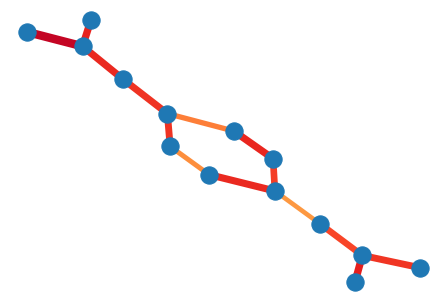

In [38]:
explain_molecule(test_data_list[2], epochs=50)

In [127]:
from standardiser import standardise
from tqdm import tqdm
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric
from rdkit.Chem import MolToSmiles, MolFromSmiles

In [155]:
data = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_4_smiles.csv', index_col=0)

In [157]:
standardised_mols = []
scaffolds = []
scaffolds_generic = []
for i in data['smiles']:
    try:
        new_mol = standardise.run(i)
        standardised_mols.append(new_mol)
        scaffolds_generic.append(MolToSmiles(MakeScaffoldGeneric(MolFromSmiles(new_mol))))
    except Exception as e:
        print(e)
        scaffolds_generic.append(0)
        standardised_mols.append(0)

No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components


RDKit ERROR: [11:14:53] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components


RDKit ERROR: [11:14:55] Can't kekulize mol.  Unkekulized atoms: 0 2 4 6 7 9
RDKit ERROR: 


No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solva

In [158]:
data['generic_scaffolds'] = scaffolds_generic
data['standardised_smiles'] = standardised_mols

# Kernel density estimate

In [764]:
from rdkit import Chem, DataStructs
import umap
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from smiles_only.data_utils import smiles2graph

In [ ]:
data = pd.read_csv()

In [567]:
scaffolds_df = pd.DataFrame(data['scaffolds'].value_counts())
unique_scaffolds = list(scaffolds_df.loc[scaffolds_df['scaffolds'] == 1].index)

In [699]:
scaffolds_df['scaffolds']

CC(C)C                                        7
CC(C)CCCC1C2CCCCC2CCC2CCCCC21                 5
CC                                            5
CC(C)CCC(C1CCCCC1)C1CCC(C)CC1                 5
CC(C)C1C(C)CCC2C(CC(C)C(C)C3CCCCC3)C(C)C21    4
                                             ..
CCCCCC(C)CC(C)(C)C1CCC(C)CC1                  1
CC(C)C1CCC(C)C1CC1CCCC2CCCC21                 1
CC(C)CC(C)(C)C                                1
CCC1CC(C)(CC)C(C)C1C                          1
CC1CCC2CC3CCCCC3C3CC(C)CC3C2C1                1
Name: scaffolds, Length: 1910, dtype: int64

In [577]:
train, test = train_test_split(data_unique_scaffolds, test_size=0.20, stratify=data_unique_scaffolds['wd_consensus_1'])

In [589]:
train_fps = []
for i in train['standardized_smiles']:
    mol = Chem.MolFromSmiles(i)
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    array = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, array)
    train_fps.append(array)

In [684]:
scores = []
n_components = []
umapper = umap.UMAP(
n_components=2,
metric='jaccard',
learning_rate=0.5,
low_memory=True,
transform_seed=42,
random_state=42,
n_neighbors=200,
)
umap_embeddings = umapper.fit_transform(train_fps)
params = {'bandwidth': np.logspace(-1 , 1, 20)}
grid = GridSearchCV(KernelDensity(), params, n_jobs=-1)
grid.fit(
    umap_embeddings
    )
scores.append(grid.best_estimator_.score(umap_embeddings))

/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [694]:
first_quartile = train['kde_prob'].describe()['25%']
second_quartile = train['kde_prob'].describe()['50%']
third_quartile = train['kde_prob'].describe()['75%']

In [690]:
train['kde_prob'] = np.exp(grid.best_estimator_.score_samples(umap_embeddings))

/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

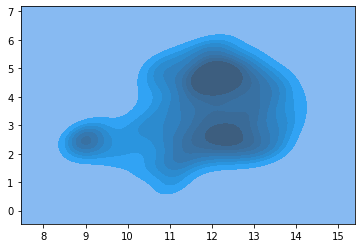

In [686]:
sns.kdeplot(umap_embeddings[:, 0], umap_embeddings[:, 1], fill=True, shade_lowest=True)

In [736]:
data = train

In [760]:
data_unique_scaffolds['stratify_label'] = data_unique_scaffolds['wd_consensus_1'].astype(str) + data_unique_scaffolds['kde_quartile']

/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [757]:
data_unique_scaffolds['stratify_label']

9295    0second
2722     0third
6826    0fourth
819      0first
4609    0fourth
         ...   
8316     0third
7238     0third
6358     0third
1815     0third
1912    0fourth
Name: stratify_label, Length: 1398, dtype: object

In [769]:
data_fps = []
for i in data['standardized_smiles']:
    mol = Chem.MolFromSmiles(i)
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, array)
    data_fps.append(array)

umapper = umap.UMAP(
    n_components=2,
    metric='jaccard',
    learning_rate=0.5,
    low_memory=True,
    transform_seed=42,
    random_state=42,
)
seed=0
withdrawn_col = 'wd_consensus_1'
print('Performing UMAP and KDE grid search CV to stratify the chemical space across folds')
umap_embeddings = umapper.fit_transform(data_fps)
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params, n_jobs=-1)
grid.fit(
    umap_embeddings
)
data['kde_prob'] = np.exp(grid.best_estimator_.score_samples(umap_embeddings))
first_quartile = data['kde_prob'].describe()['25%']
second_quartile = data['kde_prob'].describe()['50%']
third_quartile = data['kde_prob'].describe()['75%']
data['kde_quartile'] = 'first'
data.loc[data['kde_prob'] < first_quartile, 'kde_quartile'] = 'first'
data.loc[(data['kde_prob'] > first_quartile) &
         (data['kde_prob'] <= second_quartile), 'kde_quartile'] = 'second'
data.loc[(data['kde_prob'] > second_quartile) &
         (data['kde_prob'] <= third_quartile), 'kde_quartile'] = 'third'
data.loc[data['kde_prob'] > third_quartile, 'kde_quartile'] = 'fourth'


data['stratify_label'] = data['wd_consensus_1'].astype(str) + data['kde_quartile']

scaffolds_df = pd.DataFrame(data['scaffolds'].value_counts())
unique_scaffolds = list(scaffolds_df.loc[scaffolds_df['scaffolds'] == 1].index)
data_unique_scaffolds = data.loc[data['scaffolds'].isin(unique_scaffolds)]

cv_splitter = StratifiedKFold(
    n_splits=5, 
    random_state=seed,
)

fold_ap = []
fold_auc_roc = []
cv_fold = []

for k, (train_index, test_index) in enumerate(
    cv_splitter.split(data_unique_scaffolds, data_unique_scaffolds['stratify_label'])
):
        test = data_unique_scaffolds.iloc[test_index]
        test_data_list = []
        for index, row in test.iterrows():
            test_data_list.append(smiles2graph(row, withdrawn_col))

        train_set = data_unique_scaffolds.iloc[train_index]

        train, val = train_test_split(
            train_set,
            test_size=0.2,
            stratify=train_set['stratify_label'],
            shuffle=True,
            random_state=0)
        # append common scaffolds to train
        train = pd.concat([train, data.loc[~data['scaffolds'].isin(unique_scaffolds)]])

        train_data_list = []
        for index, row in train.iterrows():
            train_data_list.append(smiles2graph(row, withdrawn_col))

        # balanced sampling of the minority class
        withdrawn = train[withdrawn_col].value_counts()[1]
        approved = train[withdrawn_col].value_counts()[0]
        class_sample_count = [approved, withdrawn]
        weights = 1 / torch.Tensor(class_sample_count)
        samples_weights = weights[train[withdrawn_col].values]

Performing UMAP and KDE grid search CV to stratify the chemical space across folds


/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KeyError: 3

## Butina clustering

In [134]:
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import seaborn as sns
from rdkit import Chem, DataStructs
import umap

In [215]:
from rdkit.ML.Cluster.Butina import ClusterData

In [315]:
data = data.reset_index()

In [316]:
data_fps = []
for i in data['standardized_smiles']:
    mol = Chem.MolFromSmiles(i)
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    #array = np.zeros((0,), dtype=np.int8)
    #DataStructs.ConvertToNumpyArray(fp, array)
    #data_fps.append(array)
    data_fps.append(fp)

In [317]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [318]:
def cluster_fingerprints(fingerprints, cutoff=0.8):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [319]:
clusters = cluster_fingerprints(data_fps)

## Conformal

In [290]:
from sklearn.metrics import average_precision_score, precision_score, recall_score
import numpy as np
import seaborn as sns

In [232]:
conformal = pd.read_csv('/home/dionizije/cross_conformal_predictions.csv', index_col=0)

In [268]:
average_precision_score(conformal['class'], conformal['probabilities'], pos_label=1)

0.16105953515350785

In [284]:
aps = []
for significance in np.arange(0, 1, 0.1):
    df = conformal.loc[(conformal['p_value_approved'] >= significance) &
                      (conformal['p_value_withdrawn'] >= significance)]
    aps.append(average_precision_score(df['class'], df['probabilities']))

/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [285]:
aps

[0.16105953515350785,
 0.16552905459513442,
 0.16839237208564295,
 0.18043940087123286,
 0.1862442149650835,
 0.2059446704167201,
 0.2216218360194042,
 0.2294871794871795,
 0.23685897435897435,
 nan]

/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

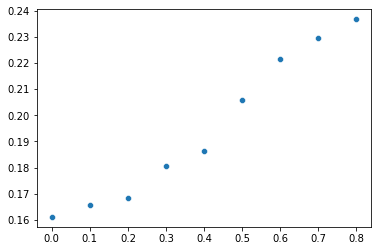

In [288]:
sns.scatterplot(np.arange(0, 1, 0.1), aps)

In [320]:
aps = []
for significance in np.arange(0, 1, 0.01):
    positives = conformal.loc[conformal['p_value_withdrawn'] >= significance]
    positives['predicted'] = 1
    negatives = conformal.loc[conformal['p_value_approved'] >= significance]
    negatives['predicted'] = 0
    df = pd.concat([positives, negatives])
    aps.append(average_precision_score(df['class'], df))

/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dionizije/anaconda3/envs/withdrawn/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dionizije/anaconda3/envs/withdrawn

In [658]:
from tdc.single_pred import ADME, Tox
from standardiser import standardise

In [668]:
    adme = ['Caco2_Wang', 'HIA_Hou', 'Pgp_Broccatelli', 'Bioavailability_Ma',
            'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB',
            'BBB_Martins', 'PPBR_AZ', 'VDss_Lombardo', 'CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
            'CYP1A2_Veith', 'CYP2C9_Veith', 'CYP2C9_Substrate_CarbonMangels', 'CYP2D6_Substrate_CarbonMangels',
            'CYP3A4_Substrate_CarbonMangels', 'Half_Life_Obach', 'Clearance_Hepatocyte_AZ']
    tox = ['LD50_Zhu', 'hERG', 'AMES', 'DILI', 'Skin Reaction', 'Carcinogens_Languin', 'ClinTox']
    tox_21 = ['nr-ar', 'nr-ar-lbd', 'nr-ahr', 'nr-aromatase', 'nr-er', 'nr-er-lbd', 'nr-ppar-gamma', 'sr-are',
              'sr-atad5', 'sr-hse', 'sr-mmp', 'sr-p53']

In [680]:
tasks = []
minority_class = []

for task in tox:
    data = Tox(name=task)
    split = data.get_split()
    train = split['train']
    valid = split['valid']
    test = split['test']
    tasks.append(task)
    try:
        minority_class.append(train['Y'].value_counts(normalize=True)[1])
    except:
        minority_class.append('regression')

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


In [681]:
tasks

['LD50_Zhu',
 'hERG',
 'AMES',
 'DILI',
 'Skin Reaction',
 'Carcinogens_Languin',
 'ClinTox']

In [682]:
minority_class

['regression',
 0.6768558951965066,
 0.5416175893207695,
 0.48493975903614456,
 0.6925795053003534,
 0.21428571428571427,
 0.07640232108317214]

In [694]:
    data = Tox(name='LD50_Zhu')
    split = data.get_split()
    train = split['train']

Found local copy...
Loading...
Done!


In [704]:
(train.iloc[0]['Y'] == 0) or (train.iloc[0]['Y'] == 1)

False